2018 Sep 24<br>
Exploring the use of BEER_curve

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from astropy import units as u

from statsmodels.robust.scale import mad
from scipy.optimize import curve_fit
from numpy.random import normal

from lightkurve import KeplerLightCurveFile

from evilmc import evparams, evmodel, convert_Kz
from transit_utils import bindata, transit_duration
from variable_eclipses_utils import retreive_data

from BEER_curve import BEER_curve

KIC = 4570949

In [2]:
# The system parameters as reported in Faigler et al. (2013) --
#  http://iopscience.iop.org/article/10.1088/0004-637X/771/1/26/meta
a = 1./0.221 #± 0.003
b = 0.944 # ± 0.011
inc = 78.0 # ± 0.2
per = 1.54492875*u.day # ± 0.00000027
Kz_m_per_s = 308. # ± 20.
Kz = convert_Kz(Kz=Kz_m_per_s) # convert to fraction of the speed of light

Mp = 2.00*u.jupiterMass # ± 0.26
Rp_over_a = 0.0214 # ± 0.0008
Rp_over_Rs = Rp_over_a*a
Ms = 1.2*u.solMass # ± 0.2
q = (Mp.to('kg')/Ms.to('kg')).value

vsini = 6500.*u.m/u.s # ± 2000
Rs = 1.32*u.solRad #± 0.08
Omegas = vsini.to('m/s')/Rs.to('m')*per.to('s') # stellar rotation state - very little effect, so chosen arbitrarily

Ts = 6300. # ± 200
Faigler_T0 = (737.49 + 2455000. - 2454833.)# % per.to('day').value # ±0.19
T0 = 0.68508434

coeffs = [0.313, 0.304]

Aplanet = 60.4e-6 # ± 2.0
F0 = 60.4e-6 # ± 2.0 -- overall shift in light curve, which is arbitrary
phase_shift = -10.3/360. # ± 2.0 - convert phase shift angle from degrees to orbital phase

beta = 0.0716671 # Interpolation from among the values reported in Claret & Bloemen (2011) A&A 529, 75

# Save parameters to an evilmc parameters object
saved_ep = evparams(per=per.to('day').value, a=a, T0=T0, p=Rp_over_Rs, limb_dark="quadratic", b=b, 
                    F0=F0, Aplanet=Aplanet, phase_shift=phase_shift, beta=beta, q=q, Kz=Kz, Ts=Ts, Ws=[0.,0.,Omegas], 
                    u=coeffs)

In [3]:
# 2018 Sep 5 - As a way of minimizing compute time while maximizing the eclipse signal, 
#   I'll take a binsize of 30-min and a boxcar window size equal to one orbital period.
num_period = 1
binsize = 30./60./24.
    
# Retrieve while masking out transit
time, flux, filtered_time, filtered_flux = retreive_data(saved_ep.per, num_periods=num_period, 
                                                         KIC=KIC, fit_bottom=True, params=saved_ep, drop_outliers=True)
folded_time = filtered_time % saved_ep.per

# Estimate scatter
dur = transit_duration(saved_ep)
ind = ~(np.abs(folded_time - saved_ep.T0) < dur)
unbinned_noise = mad(filtered_flux[ind])
print(unbinned_noise*1e6)

141.83679022846894


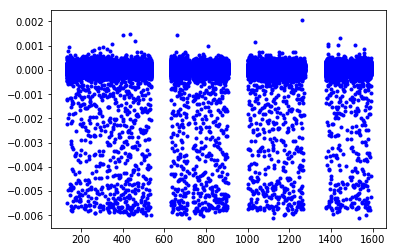

In [4]:
# Initial fit using Faigler's parameters (with my own T0)
plt.plot(filtered_time, filtered_flux, 'b.')

CPU times: user 1.02 s, sys: 449 ms, total: 1.47 s
Wall time: 1.48 s


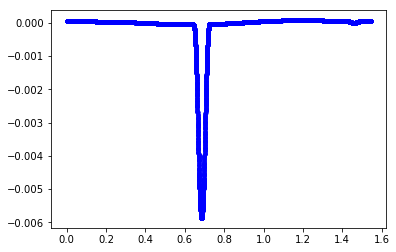

In [5]:
# Setting parameters for BEER_curve
saved_params = {
    "per": saved_ep.per,
    "i": inc,
    "a": saved_ep.a,
    "T0": saved_ep.T0,
    "p": saved_ep.p,
    "linLimb": saved_ep.u[0],
    "quadLimb": saved_ep.u[1],
    "b": saved_ep.b,
    "Aellip": 21.1e-6,
    "Abeam": 13.5e-6,
    "F0": 0.,
    "Aplanet": 50.4e-6,
    "phase_shift": saved_ep.phase_shift
    }

BC = BEER_curve(folded_time, saved_params, supersample_factor=100, exp_time=30./60./24.)
%time plt.plot(folded_time, BC.all_signals(), 'b.')

[0.09683257918552035, 0.944, 0.68508434, 2.11e-05, 1.35e-05, 0.0, 5.04e-05, -0.02861111111111111]
CPU times: user 23.8 s, sys: 9.06 s, total: 32.9 s
Wall time: 33.5 s
[ 1.04967649e-01  9.58786944e-01  6.84991344e-01  1.26174015e-05
 -3.04666144e-05  3.21516834e-05  6.15711028e-05 -1.14441704e-01]
[6.29453273e-04 1.03039145e-03 1.94911623e-05 1.00651197e-06
 2.05702623e-04 1.28031638e-06 1.35501030e-04 4.00101444e-01]
(148.14142459844712, -0.31590833647739586)


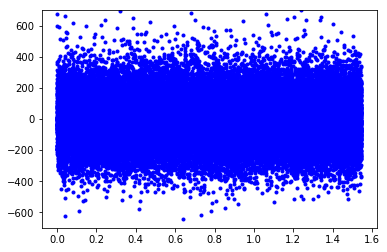

In [6]:
def fit_sinusoids(cur_time, cur_p, cur_b, cur_T0, cur_Aellip, cur_Abeam, cur_F0, cur_Aplanet, cur_phase_shift):
    params = saved_params.copy()
    
    params['p'] = cur_p
    params['b'] = cur_b
    params['T0'] = cur_T0
    params['Aellip'] = cur_Aellip
    params['Abeam'] = cur_Abeam
    params['F0'] = cur_F0
    params['Aplanet'] = cur_Aplanet
    params['phase_shift'] = cur_phase_shift
    
    cur_BC = BEER_curve(cur_time, params, supersample_factor=10, exp_time=30./60./24.)
    
    return cur_BC.all_signals()

# Estimate scatter
dur = transit_duration(saved_ep)
ind = ~(np.abs(folded_time - saved_ep.T0) < dur)
unbinned_noise = mad(filtered_flux[ind])

time = folded_time
data = filtered_flux
err = unbinned_noise*np.ones_like(folded_time)

initial_guess = [saved_params['p'], saved_params['b'], saved_params['T0'],
                 saved_params['Aellip'], saved_params['Abeam'], saved_params['F0'], 
                 saved_params['Aplanet'], saved_params['phase_shift']]
print(initial_guess)
%time popt, pcov = curve_fit(fit_sinusoids, time, data, sigma=unbinned_noise*np.ones_like(time), p0=initial_guess, bounds=([0., -1, saved_params['T0']*0.95, -500e-6, -500e-6, -500e-6, -500e-6, -1], [0.2, 1., saved_params['T0']*1.05, 500e-6, 500e-6, 500e-6, 500e-6, 1]))
print(popt)
print(np.sqrt(pcov.diagonal()))

# plt.plot(time, data, 'b.')
# plt.plot(time, fit_sinusoids(time, *popt), 'r.')

resid = data - fit_sinusoids(time, *popt)
plt.plot(time, resid*1e6, 'b.')
plt.ylim([-700, 700])

print(np.std(resid)*1e6, np.mean(resid)*1e6)

2018 Sep 28<br>
Experimenting to make sure BEER curve can recover variable eclipses.

5.9164933089137374e-05


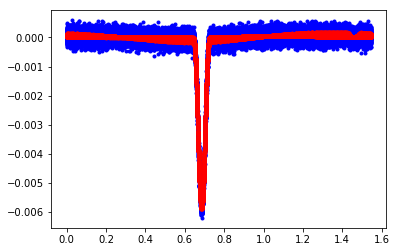

In [75]:
# 2018 Sep 28 - Just as a check, let's try a more complicated behavior.
# Now I'd like to make the eclipse depth vary sinusoidally from orbit to orbit, stack the eclipses all together,
# and see what eclipse depth I get.
which_orbit = np.floor((filtered_time - Faigler_T0)/saved_params['per'])
which_orbit -= np.min(which_orbit)
which_orbit_unq = np.unique(which_orbit)
which_orbit_midtime = which_orbit_unq*saved_params['per']

eclipse_variability_period = 10.*saved_params['per'] # eclipse depth will vary with a period equal to 10 orbits
eclipse_variability_amplitude = saved_params['F0'] + saved_params['Aplanet']
eclipse_depths = np.abs(eclipse_variability_amplitude + normal(size=len(which_orbit_midtime), 
                                                         scale=eclipse_variability_amplitude))

synthetic_times = np.array([])
synthetic_eclipses = np.array([])
noisy_synthetic_eclipses = np.array([])
for i in range(len(which_orbit_unq)-1):
    mn = which_orbit_unq[i]*saved_ep.per + np.min(filtered_time)
    mx = (which_orbit_unq[i] + 1)*saved_ep.per + np.min(filtered_time)
    
    ind = (filtered_time >= mn) & (filtered_time < mx)
    
    if(filtered_time[ind].size > 0):
    
        synthetic_times = np.append(synthetic_times, filtered_time[ind])
        cur_Aplanet = eclipse_depths[i] - saved_params['F0']

        cur_eclipse = fit_sinusoids(filtered_time[ind] % saved_params['per'], 
                                    saved_params['p'], saved_params['b'], saved_params['T0'], 
                                    saved_params['Aellip'], saved_params['Abeam'], 
                                    saved_params['F0'], cur_Aplanet, saved_params['phase_shift'])
        synthetic_eclipses = np.append(synthetic_eclipses, cur_eclipse)

        noisy_synthetic_eclipses = np.append(noisy_synthetic_eclipses, 
                                             cur_eclipse + normal(size=len(cur_eclipse), 
                                                                  scale=unbinned_noise))

    
plt.plot(synthetic_times % saved_params['per'], noisy_synthetic_eclipses, 'b.')
plt.plot(synthetic_times % saved_params['per'], synthetic_eclipses, 'r.')
#plt.xlim([1.4, 1.5])

men = np.mean(eclipse_depths)
print(men)

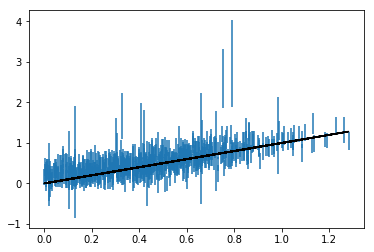

In [78]:
def fit_eclipse_depth(cur_time, cur_F0, cur_Aplanet, cur_phase_shift):
    params = saved_params.copy()
    
    params['F0'] = cur_F0
    params['Aplanet'] = cur_Aplanet
    params['phase_shift'] = cur_phase_shift
    
    cur_BC = BEER_curve(cur_time, params, supersample_factor=10, exp_time=30./60./24.)
    
    return cur_BC.all_signals()

# fit_eclipse_depths = np.array([])
# fit_eclipse_depth_errs = np.array([])
# for cur_which_orbit in which_orbit_unq:
#     mn = cur_which_orbit*saved_ep.per + np.min(synthetic_times)
#     mx = (cur_which_orbit + 1)*saved_ep.per + np.min(synthetic_times)
    
#     ind = (synthetic_times >= mn) & (synthetic_times < mx)
#     time = synthetic_times[ind] % saved_params['per']
#     data = noisy_synthetic_eclipses[ind]
    
#     initial_guess = [saved_params['F0'], saved_params['Aplanet'], saved_params['phase_shift']]
    
#     if(time.size > 30):
    
#         try:
#             popt, pcov = curve_fit(fit_eclipse_depth, time, data, sigma=unbinned_noise*np.ones_like(time), 
#                                    p0=initial_guess, 
#                                    bounds=([-500e-6, -500e-6, -1], 
#                                            [500e-6, 500e-6, 1]))

#             fit_eclipse_depths = np.append(fit_eclipse_depths, popt[0] + popt[1])
#             # https://en.wikipedia.org/wiki/Propagation_of_uncertainty#Example_formulas
#             fit_eclipse_depth_errs = np.append(fit_eclipse_depth_errs, 
#                                                np.sqrt(pcov[0,0] + pcov[1,1] + 2*np.sqrt(pcov[0,1]*pcov[1,0])))
#         except:
#             fit_eclipse_depths = np.append(fit_eclipse_depths, 0.)
#             fit_eclipse_depth_errs = np.append(fit_eclipse_depth_errs, 0.)
#     else:
#         fit_eclipse_depths = np.append(fit_eclipse_depths, 0.)
#         fit_eclipse_depth_errs = np.append(fit_eclipse_depth_errs, 0.)
        
ind = (fit_eclipse_depth_errs/unbinned_noise) > 0
plt.errorbar((eclipse_depths/unbinned_noise)[ind], (fit_eclipse_depths/unbinned_noise)[ind], 
             (fit_eclipse_depth_errs/unbinned_noise)[ind], ls='')
plt.plot((eclipse_depths/unbinned_noise), (eclipse_depths/unbinned_noise), 'k')

# plt.plot(which_orbit_unq, fit_eclipse_depths/fit_eclipse_depth_errs, 'b.')
# print(which_orbit_unq[(fit_eclipse_depths/fit_eclipse_depth_errs).argmax()])

#plt.ylim([0, 20])